In [ ]:
import numpy as np
import librosa
import joblib

MODEL_PATH  = "/Users/omarhassan/Desktop/projects/gender_class/xgb_gender_model_cleaned.pkl"
SCALER_PATH = "/Users/omarhassan/Desktop/projects/gender_class/scaler_cleabed.pkl"
#AUDIO_PATH  = "gender_data/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav"


In [ ]:
import numpy as np
import librosa
from scipy.signal import butter, filtfilt

def pre_emphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def butter_bandpass(lowcut, highcut, sr, order=2):
    nyq = 0.5 * sr
    low = max(lowcut / nyq, 1e-6)
    high = min(highcut / nyq, 0.9999)
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(signal, sr, lowcut=80.0, highcut=8000.0, order=2):
    b, a = butter_bandpass(lowcut, highcut, sr, order)
    return filtfilt(b, a, signal)

def spectral_subtraction(signal, sr, n_fft=2048, hop_length=512, noise_duration=0.5, oversub=1.5, floor_coef=0.1):
    num_noise = min(int(noise_duration * sr), signal.shape[0])
    if num_noise < 1:
        return signal
    noise_clip = signal[:num_noise]
    S_full = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    S_noise = librosa.stft(noise_clip, n_fft=n_fft, hop_length=hop_length)
    noise_mag = np.mean(np.abs(S_noise), axis=1, keepdims=True)
    S_mag, S_phase = np.abs(S_full), np.angle(S_full)
    S_clean_mag = np.maximum(S_mag - oversub * noise_mag, floor_coef * noise_mag)
    S_clean = S_clean_mag * np.exp(1j * S_phase)
    return librosa.istft(S_clean, hop_length=hop_length, length=signal.shape[0])

def normalize_signal(signal):
    m = np.max(np.abs(signal))
    return signal / m if m > 0 else signal

def preprocess_audio(path, sr=16000):
    signal, _ = librosa.load(path, sr=sr)
    signal = pre_emphasis(signal)
    signal = bandpass_filter(signal, sr)
    signal = spectral_subtraction(signal, sr)
    signal = normalize_signal(signal)
    return signal, sr


In [2]:
def extract_mfcc_features(file_path, sr=16000, n_mfcc=13, n_fft=2048, hop_length=512):
    y, _    = librosa.load(file_path, sr=sr)
    mfcc    = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    delta1  = librosa.feature.delta(mfcc)
    delta2  = librosa.feature.delta(mfcc, order=2)
    return np.vstack([mfcc, delta1, delta2])

def summarize_features(feat_mat):
    means = feat_mat.mean(axis=1)
    stds  = feat_mat.std(axis=1)
    return np.concatenate([means, stds]).reshape(1, -1)


In [3]:
model  = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)


In [ ]:
AUDIO_PATH = "path/to/your/audio.wav"

signal, sr = preprocess_audio(AUDIO_PATH)
feat_mat = extract_mfcc_features(signal, sr)
feat_vec = summarize_features(feat_mat)
feat_scaled = scaler.transform(feat_vec)

pred = model.predict(feat_scaled)[0]
conf = model.predict_proba(feat_scaled)[0][pred]
label = "female" if pred == 1 else "male"

print(f"File: {AUDIO_PATH}")
print(f"Predicted gender: {label} (confidence: {conf:.2f})")


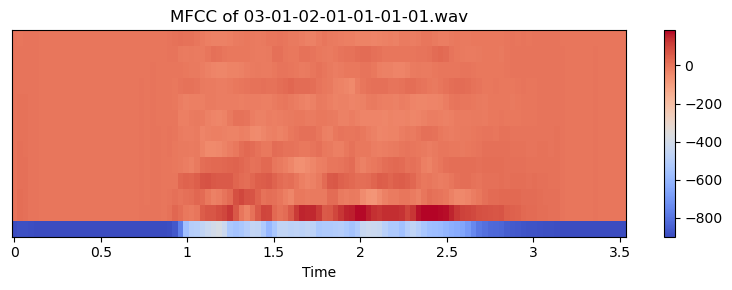

In [5]:
import matplotlib.pyplot as plt
mfcc = extract_mfcc_features(AUDIO_PATH)[:13]  # static MFCC only
plt.figure(figsize=(8,3))
librosa.display.specshow(mfcc, x_axis="time", sr=16000, hop_length=512)
plt.title(f"MFCC of {AUDIO_PATH.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
AUDIO_PATH = "path/to/your/audio.wav"

signal, sr = preprocess_audio(AUDIO_PATH)
feat_mat = extract_mfcc_features(signal, sr)
feat_vec = summarize_features(feat_mat)
feat_scaled = scaler.transform(feat_vec)

pred = model.predict(feat_scaled)[0]
conf = model.predict_proba(feat_scaled)[0][pred]
label = "female" if pred == 1 else "male"

print(f"File: {AUDIO_PATH}")
print(f"Predicted gender: {label} (confidence: {conf:.2f})")


File: gender_data/audio_speech_actors_01-24/Actor_02/03-01-02-01-01-01-02.wav
Predicted gender: female (confidence: 1.00)


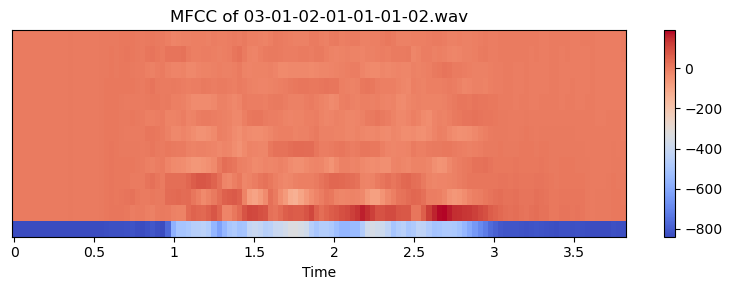

In [8]:
import matplotlib.pyplot as plt
mfcc = extract_mfcc_features(AUDIO_PATH)[:13]  # static MFCC only
plt.figure(figsize=(8,3))
librosa.display.specshow(mfcc, x_axis="time", sr=16000, hop_length=512)
plt.title(f"MFCC of {AUDIO_PATH.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()
plt.show()
